Statistical significance
* Whether an experiment yields a result more extreme than what chance might produce, thus is beyond the chance variation, and said to be statistically significant.

P-value
* The probability of obtaining results as unusual or extreme as the observed results. The probability that, given a chance model, results as extreme as the observed results would occur.

Alpha
* the probability that chance results must surpass for actual outcomes to be deemed statistically significant. Typical alpha levels are 0.05 or 0.01. Any chosen level is arbitrary.

Type 1 error
* Concluding an effect is present when it is not

Type 2 error
* Concluding an effect is not present when it is

In [15]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact
import statsmodels.api as sm

In [2]:
df_seed = pd.read_csv('/home/satire/PycharmProjects/Statistics/csv/click_rates.csv')
df = df_seed.pivot(index='Headline', columns='Click', values='Rate')
df

Click,Click,No-click
Headline,,
Headline A,14,986
Headline B,8,992
Headline C,12,988


In [3]:
def perm_fun(x, n_control, n_variant):
    n = n_control + n_variant
    idx_variant = list(random.sample(range(n), n_variant))
    idx_control = list(set(range(n)) - set(idx_variant))
    return x.loc[idx_control].mean() - x.loc[idx_variant].mean()

In [4]:
obs_pct_diff = 100 * (14 / 986 - 8 / 992)
print(f'Observed difference: {obs_pct_diff:.4f}%')

Observed difference: 0.6134%


The number of zeros match the overall sample size minus the total number of successes, which is 1978 items in total (986 + 992) with 22 ones and 1956 zeros.

In [5]:
conversion = [1] * 22 + [0] * (1978 - 22)
conversion = pd.Series(conversion)
perm_diffs = [100 * perm_fun(conversion, 986, 992) for _ in range(1000)]

Text(0, 0.5, 'Frequency')

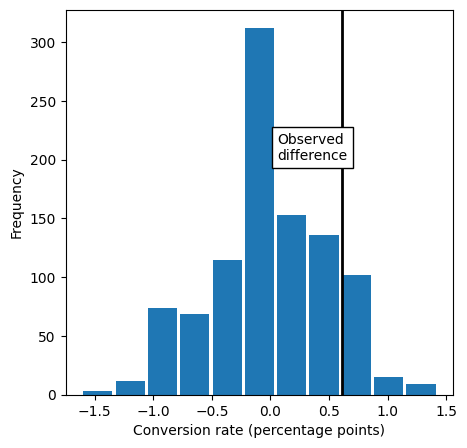

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor': 'white'})
ax.set_xlabel('Conversion rate (percentage points)')
ax.set_ylabel('Frequency')

In [7]:
p_value = np.mean([diff > obs_pct_diff for diff in perm_diffs])
print(f'P-value: {p_value:.4f}')

P-value: 0.0610


* Estimating the p-value from the permutation test by taking the proportion of times that the permutation test produces a difference equal to or greater than the observed difference.

* Since we have a binomial distribution, we can aproximate the p-value using the chi-squared test

In [8]:
conversions = np.array([[8, 986 - 8], [14, 992 - 14]])
chi2, p_value, df, _ = chi2_contingency(conversions)
print(f'p-value for a single sided test: {p_value / 2:.4f}')

p-value for a single sided test: 0.1451


* Hypothesis tests are a way to protect against being fooled by randomness.

Relevance
* Chi-square test, Fisher's exact test is used when you want to know whether an effect is for real or might be the product of chance.
* Chi-square test role is to establish statistical significance
* Determine appropriate sample sizes.
* Due to experiments sometimes having low rates, being too small to yield definitive conclusions in a experiment.
* For example(propensity to buy a particular item is independent of gender)
* Chi-square distribution is a reference distribution(Embodies the assumption of independence) to which observed calculated chi-squared statistic must be compared.


Chi_Square Test
* Test used with count data to test how well it fits some expected distribution, The most common use is with 2 x 3 contingency tables, to assess whether the null hypothesis of independence among variables is reasonable.
* A measure of extent to which some observed data departs form expectation
* How well we would expect the data to turn out under some assumption(null hypothesis)

The Pearson Residual is defined as:
$$
r_i = \frac{y_i - \hat{\mu}_i}{\sqrt{\text{Var}(y_i)}}
$$

* Measuring the extent to which the actual counts differ from these expected counts in which ${y_i}$ represents the expected values and ${\hat{\mu}_i}$ represents the observed values

The chi-square statistic is defined as the sum of the squared Pearson residuals:
$$
\chi^2 = \sum_{i} \frac{(O_i - E_i)^2}{E_i}
$$

* Where $_i$ represents the number os rows and columns, respectively
* $X_2$ measures the extent to which the actual counts differ from these expected counts

Resampling algorithm
* Constitute a box with the number of ones (yes) and the number of zeros (no)
* Shuffle, take three separate samples of the total number of samples and count the values in each.
* Find the squared differences between the shuffled counts and the expected counts and sum them
* Repeat steps 2 and 3, 1000 times.
* The amount exceed from the resampled sum of squared deviations is the p-value.

In [9]:
table = df_seed.pivot_table(index='Click', columns='Headline', values='Rate')
table

Headline,Headline A,Headline B,Headline C
Click,,,
Click,14.0,8.0,12.0
No-click,986.0,992.0,988.0


In [10]:
box = [1] * 34 # A box with number ones (yes)
box.extend([0] * 2966) # A box with number of zeros (no)
random.shuffle(box) # Shuffle the box

def chi2(observed, expected): # The observed and expected values
    pearson_residuals = [] # The extent to which the actual counts differ from the expected counts
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row]) # Find the squared differences between the shuffled counts and the expected counts
        return np.sum(pearson_residuals) # and sum them

expected_clicks = 34 / 3 # take three separate samples of 1000 (total number of each sample)
expected_noclicks = 1000 - expected_clicks
expected = [34 / 3, 1000 - 34 / 3]
chi2observed = chi2(table.values, expected) # Count the values in each

In [11]:
def perm_fun(box): # Repeat steps 2 and 3, 1000 times.
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)
perm_chi2 = [perm_fun(box) for _ in range(2000)]

In [12]:
# The amount exceed from the resampled sum of squared deviations is the p-value
resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6471
Resampled p-value: 0.4800


Chi-Square test:
* Statistical Theory shows that the distribution of the chi-square statistic can be approximated by a chi-square distribution
* The appropriate standard chi-square distribution is determined by the degrees of freedom
* A contingency table, the degrees of freedom are related to the number of rows and columns as follows:
$$\text{degrees of freedom} = (r - 1) \times (c - 1)$$

* Typically skewed, with a long tail to the right
* For a Distribution with 1,2,5 and 20 degrees of freedom, the further out on the chi-square distribution the observed statistic is, the lower the p-value.

In [13]:
chisq, pvalue, df, expected = chi2_contingency(table)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'p-value: {pvalue:.4f}')

Observed chi2: 1.6471
p-value: 0.4348


* The p-value is a little less than the resampling p-value, because the chi-square distribution is only an approximation of the actual distribution of the statistic.

Fisher's Exact test
* When counts are extremely low(single digits, especially five or fewer).
* Procedure to enumerate all the possible rearrangements(permutations) that can occur, tabulate their frequencies and determine exactly how extreme the observe result is

In [14]:
res = fisher_exact(table)
res.pvalue

np.float64(0.4623)

Multi-Arm bandit Algorithm
* Offer an approach to testing that allows explicit optimization and more rapid decision making than traditional statistical approach
* Multiple arms for a customer to choose form, each with different payoffs, multitreatment experiment.

Arm
* A treatment in an experiment(A feature)

Win
* The experimental analog of a win at a slot machine

Example results of an experiment
* Arm A: 10 wins out of 50
* Arm B: 2 win out of 50
* Arm C: 4 wins out of 50

Epsilon-greedy algorithm for A/B Test
* Generate a uniformly distributed random number between 0 and 1
* If te number lies between 0 and epsilon(Number between 0 and 1), flip a fair coin(50/50 probability)
* If the coin is heads, show offer A
* If the coin is tails, show offer B
* If the number is > epsilon, show whichever offer has had the highest response rate to date
* Epsilon is a single parameter: If is 1, we end up with a standard simple A/B test
* If epsilon is 0, we end up with a purely greedy algorithm - chooses the best available immediate option, seeking no further experiment other than the best performing treatment

Thompson's sampling
* Samples a bandit arm at each stage to maximize the probability of choosing the best arm
* With each successive draw, you gain more information
* Bayesian approach: prior distribution of rewards is assumed initially, using a beta distribution
* As information accumulates from each draw, the information is updated, thus choosing the best right arm
* Handles 3+ treatments and move toward optimal selection of the best
* The advantage for multiple treatments is much greater

Power and Sample size
* How long a test should run(how many impressions per treatment are needed)
* It depends on the frequency with which the desired goal is attained

Effect size
* The minimum size of the effect that you hope to be able to detect in a statistical test, such as "20 % of improvement"

Power
* The probability of detecting a given effect size with a given sample size and variability
* Example: Hypothetically the probability of distinguishing between .330 and .200 in 25 attempts is 0.75
* The effect size is a difference of .130
* Hypothesis test will reject the null hypothesis of "no difference and conclude there is a real effect
* Conclusion: 25 attempts for two treatments, with an effect size of 0.130, has hypothetical power of 0.75(75 %)

Significance level
* The statistical significance level at which the test will be conducted

* Always ask "Will a hypothesis test actually reveal a difference between treatments A and B?
* The outcome os a hypothesis is the p-value, also depending on the luck of the draw, the bigger the actual difference between them, the greater the probability that our experiment will reveal it, the smaller the difference, the more data will be needed to detect it
* Example: .350 - 200 (not many data are needed)
* Example: .300 and .280, a good many more will be needed

Intuitive approach to collect data at a fairly cost
* Start with some hypothetical data that represents your best guess about the data that will result -for example a box with 20 ones and 80 zeros to represent .200 match, or a box with some observations
* Create a second sample simply adding the desired effect size to the first sample - 33 ones and 67 zeros
* Draw a bootstrap sample size $_n$ from each box
* Conduct a permutation hypothesis test on the two bootstrap samples and record whether the difference between them is statistically significant
* Repeat the preceding two steps many times and determine how often the difference was significant - estimated power

Sample size
* Estimate how big a sample will be needed
* Big difference - minor sample will be needed (50% difference)
* Minor difference - big sample will be needed
* Establish a policy that a new treatment must be superior than an existing one by some percentage(at least 10%), otherwise the existing one will remain in place(the effect size that drives the sample size)

Example
* Your rate is about 1.1% and you are seeking 10% boost to 1.21%
* We have two boxes - A with 1.1% ones(110 ones and 9,890 zeros) and a box B with 1.21% ones(121 ones and 9,879 zeros)
* Try 300 draws from each box at the start(300 impressions for each treatment)
* Results are as follows:
* Box A: 3 ones
* Box B: 5 ones
* Any hypothesis test would reveal this difference to be within the range of chance variation
* Combination is too small
* $_n = 300$ in each group and effect size (10% difference) for any hypothesis test to show a difference

Calculating power
* Sample size
* Effect size you want to detect
* Significance level (alpha) at which the test will be conducted
* Power
* After calculating, specify the alternative hypothesis as greater or larger to get one a one-sided test

In [16]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size,
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 116602.391
